# Links
 
- [Competition homepage](https://www.kaggle.com/c/lish-moa/overview/)
- [Leaderboard](https://www.kaggle.com/c/lish-moa/leaderboard)
- [Connectivity Map](https://clue.io/)
- [Connectopedia - dictionary of terms and concepts related to the Connectivity Map](https://clue.io/connectopedia/glossary)

Papers:
- [Corsello et al. “Discovering the anticancer potential of non-oncology drugs by systematic viability profiling,” Nature Cancer, 2020](https://doi.org/10.1038/s43018-019-0018-6)
- [Subramanian et al. “A Next Generation Connectivity Map: L1000 Platform and the First 1,000,000 Profiles,” Cell, 2017](https://doi.org/10.1016/j.cell.2017.10.049)

# Description

The [Connectivity Map](https://clue.io/), a project within the Broad Institute of MIT and Harvard, together with the [Laboratory for Innovation Science at Harvard (LISH)](https://lish.harvard.edu/), presents this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

#### What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

#### How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

#### How to evaluate the accuracy of a solution?

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the [logarithmic loss function](https://www.kaggle.com/c/lish-moa/overview/evaluation) applied to each drug-MoA annotation pair.

<img src="../references/logarithmic_loss_function.jpg">

If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process. 

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
plt.style.use("../style.mplstyle")

# Load Data

In this competition, you will be predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (`sig_id`), given various inputs such as gene expression data and cell viability data.

#### Two notes:

- The training data has an additional (optional) set of MoA labels that are not included in the test data and not used for scoring.
- The re-run dataset has approximately 4x the number of examples seen in the Public test.

#### Files

- `train_features.csv` - Features for the training set. Features `g-` signify gene expression data, and `c-` signify cell viability data. cp_type indicates samples treated with a compound (`cp_vehicle`) or with a control perturbation (`ctrl_vehicle`); control perturbations have no MoAs; `cp_time` and `cp_dose` indicate treatment duration (24, 48, 72 hours) and dose (high or low).
- `train_targets_scored.csv` - The binary MoA targets that are scored.
- `train_targets_nonscored.csv` - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.
- `test_features.csv` - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.
- `sample_submission.csv` - A submission file in the correct format.


## Features

In [3]:
df_trf = pd.read_csv("../data/raw/train_features.csv")
df_tef = pd.read_csv("../data/raw/test_features.csv")
df_trf["flag"] = "train"
df_tef["flag"] = "test"
df = pd.concat([df_trf, df_tef], ignore_index=True)
print(df_trf.shape, df_tef.shape)
df.sample(10)

(23814, 877) (3982, 877)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,flag
14859,id_9fbc436fe,trt_cp,24,D2,1.0900,-0.0872,-0.5483,-0.0314,0.2801,-1.6190,...,0.5914,-0.1098,0.4305,-0.1473,0.3251,-0.1364,0.1761,0.6232,-0.5260,train
8227,id_587fe7751,trt_cp,24,D2,0.1313,0.0424,2.4390,-0.3144,-0.3751,-0.2869,...,-0.6752,-1.5290,-0.1401,-0.6262,0.0757,-0.8215,-0.7750,0.4322,0.0062,train
22688,id_f3b12e703,ctl_vehicle,24,D2,-1.9280,-0.6744,-0.1395,0.9232,-1.4380,-1.1110,...,-0.1343,-0.8074,-0.3748,2.6010,0.4289,0.2076,0.5922,1.9060,-0.3557,train
530,id_057c57231,trt_cp,48,D2,0.0325,0.3736,0.2826,-0.6536,0.0362,-0.0046,...,-0.7356,0.7100,-0.0078,0.1330,-0.2212,0.0235,-1.3100,0.2099,0.6476,train
473,id_0501cc8c0,trt_cp,24,D2,-0.1226,-0.1837,0.1382,0.5113,0.2637,-0.1154,...,0.3795,-0.5367,-0.6905,-0.6308,-0.9554,0.0381,-1.3650,-0.3380,-0.4412,train
8396,id_5a680efda,trt_cp,72,D1,-1.5430,0.5803,-0.0493,0.0722,0.0403,-0.1489,...,0.8143,0.0263,0.5142,0.3981,0.6342,0.7797,0.7316,0.4757,0.2054,train
1791,id_133bf2f8b,trt_cp,72,D1,-0.3446,-1.0190,-1.0870,0.9767,-0.6267,0.9500,...,0.8720,0.4948,1.0910,0.4157,-0.1518,0.0704,-0.2099,1.3500,0.2503,train
13153,id_8da4017d5,ctl_vehicle,72,D2,-1.0070,-0.0476,-0.4326,-0.0934,0.6023,0.0764,...,0.9270,0.5388,0.6859,-0.4402,-0.7084,0.1091,-0.1340,0.4085,-0.0408,train
11483,id_7bcbe79bc,trt_cp,72,D2,4.6500,-0.2267,1.8110,-0.5721,2.5880,-0.6069,...,-10.0000,-9.6040,-10.0000,-10.0000,-9.1200,-10.0000,-9.3720,-9.9670,-6.9400,train
25934,id_8812ec85c,trt_cp,72,D2,0.1488,1.1930,0.3081,-0.1832,-0.7342,-1.5790,...,-0.4466,0.3152,-0.1030,-1.9820,-1.1730,-0.8875,-1.0750,-0.3527,-0.4559,test


#### cp_ variable counts

In [4]:
print(df["cp_type"].value_counts())
print()
print(df["cp_time"].value_counts())
print()
print(df["cp_dose"].value_counts())

trt_cp         25572
ctl_vehicle     2224
Name: cp_type, dtype: int64

48    9627
72    9097
24    9072
Name: cp_time, dtype: int64

D1    14174
D2    13622
Name: cp_dose, dtype: int64


#### Gene expression and cell viability variables

In [5]:
g_features = [c for c in df.columns if c.startswith('g-')]
c_features = [c for c in df.columns if c.startswith('c-')]
print(f"n 'g-' features: {len(g_features)}")
print(f"n 'c-' features: {len(c_features)}")
df.iloc[:, 4:].describe()

n 'g-' features: 772
n 'c-' features: 100


,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,...,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000,27796.000000
mean,0.241075,-0.091035,0.150142,0.077337,0.056643,-0.140127,0.032302,-0.197528,-0.186930,0.123331,...,-0.463619,-0.454506,-0.507885,-0.494748,-0.503097,-0.352683,-0.457815,-0.369380,-0.460884,-0.296962
std,1.390652,0.810750,1.040185,0.950057,1.026708,1.183064,0.879175,1.120297,1.738137,1.086138,...,2.002316,2.035837,1.996284,2.110182,2.158159,1.631619,2.063648,1.696918,1.828709,1.400609
min,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,-8.337000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.478125,-0.560625,-0.436925,-0.435100,-0.468425,-0.598500,-0.498125,-0.518025,-0.513300,-0.353600,...,-0.561000,-0.559025,-0.582500,-0.565300,-0.561300,-0.566400,-0.544125,-0.555325,-0.582325,-0.559400
50%,-0.017650,-0.044050,0.074800,0.000650,-0.030800,-0.015300,-0.002000,-0.014550,0.008150,0.161150,...,-0.006350,0.004750,-0.007300,-0.009650,-0.000650,-0.011800,0.006650,-0.003650,0.015750,-0.018300
75%,0.515400,0.406825,0.660000,0.458050,0.462300,0.508975,0.522100,0.413900,0.545725,0.703100,...,0.460300,0.463825,0.445100,0.456150,0.472825,0.446425,0.471550,0.450525,0.464000,0.436825
max,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,6.433000,...,4.936000,5.300000,3.927000,4.087000,5.290000,5.053000,5.276000,3.074000,3.859000,4.149000


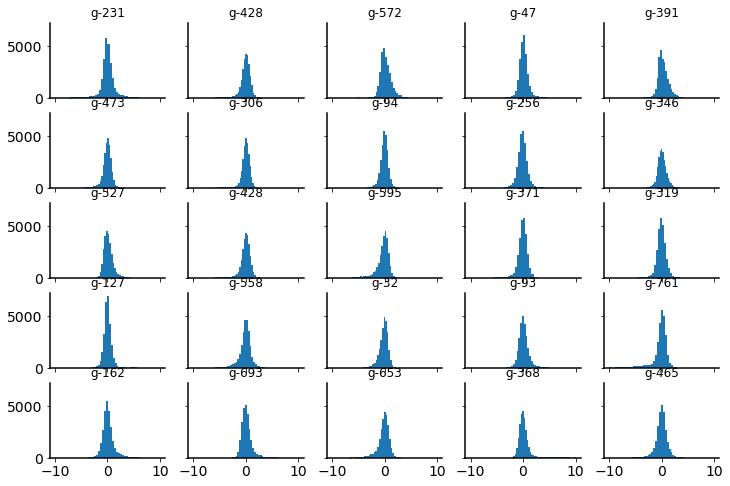

In [6]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)
ax = ax.flatten()

gs = np.random.choice(g_features, 25)
for i, g in enumerate(gs):
    ax[i].hist(df[g], bins=50)
    ax[i].set_title(g, size=12) 

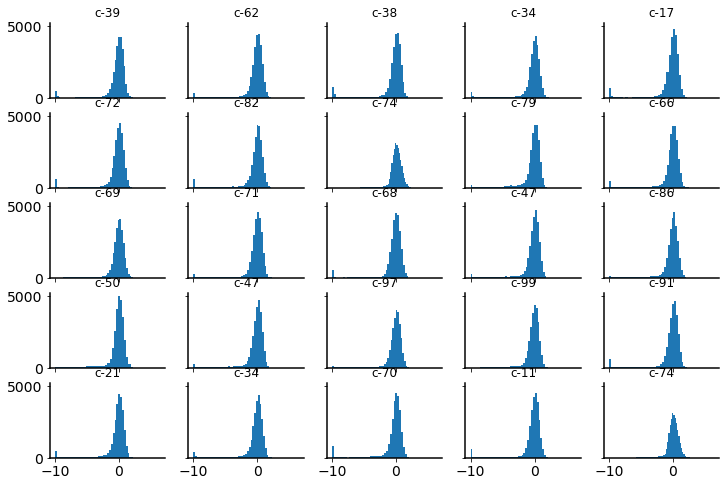

In [7]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)
ax = ax.flatten()

cs = np.random.choice(c_features, 25)
for i, c in enumerate(cs):
    ax[i].hist(df[c], bins=50)
    ax[i].set_title(c, size=12)

## Target

In [8]:
df_ttn = pd.read_csv("../data/raw/train_targets_nonscored.csv")
df_tts = pd.read_csv("../data/raw/train_targets_scored.csv")
print(df_ttn.shape, df_tts.shape)
df_tts.sample(10)

(23814, 403) (23814, 207)


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
18601,id_c7e5c7fcd,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13438,id_90e608188,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9938,id_6b1a81eda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22213,id_ee42485c6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2846,id_1e924ef1b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1795,id_1343888fe,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19297,id_cf0cc1d91,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20771,id_deb8340b2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5168,id_37872b4c9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7562,id_51385ec45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Most drugs have zero or one mechanism of action annotation. Some mechanism of action annotations occur very infrequently, whereas others are much more common.

0 7
1 832


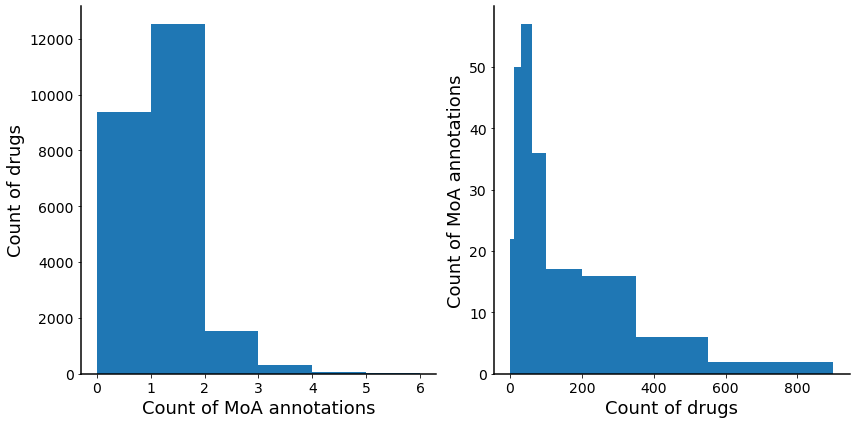

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

moa_counts = df_tts.sum(axis=1)
print(min(moa_counts), max(moa_counts))
ax[0].hist(moa_counts, bins=[0, 1, 2, 3, 4, 5, 6])
ax[0].set_xlabel("Count of MoA annotations")
ax[0].set_ylabel("Count of drugs");

moa_counts1 = df_tts.iloc[:, 1:].sum(axis=0)
print(min(moa_counts1), max(moa_counts1))
ax[1].hist(moa_counts1, bins=[0, 10, 30, 60, 100, 200, 350, 550, 900])
ax[1].set_ylabel("Count of MoA annotations")
ax[1].set_xlabel("Count of drugs")

fig.tight_layout();